In [0]:
!nvidia-smi

Tue May  5 10:45:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Your next step is to upload your code and data to the runtime. You can do that by:
- mounting your Google Drive,
- uploading directly from your computer, 
- or using Shell command to download from the web.

To mount your Google Drive:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls

capstone.ipynb  EDA.ipynb  pneumonia-detection.zip


In [0]:
cd ..

/content


In [0]:
# !cp  "drive_data"
!cp ./drive/My\ Drive/Capstone\ project/pneumonia-detection.zip ./pneumonia-detection.zip


In [0]:
cd ..

/content


In [0]:
ls

drive/  sample_data/  save/  save.zip


You will need to authenticate first then your Drive should be mounted at `/content/drive`.

To upload files directly from your computer:

In [0]:
ls

drive/  pneumonia-detection.zip  sample_data/


In [0]:
!unzip pneumonia-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_train_images/d539e101-5662-445c-9f6a-381e674f0aed.dcm  
  inflating: stage_2_trai

In [0]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom
import numpy as np
import warnings
import multiprocessing
import os

warnings.filterwarnings('ignore')

In [0]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 88kB/s 


In [0]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=.8)

In [0]:
RAWDATA_DIR = ''
PREPROCESS_DIR = ''

In [0]:
ls

 drive/                                 stage_2_sample_submission.csv
'GCP Credits Request Link - RSNA.txt'   stage_2_test_images/
 pneumonia-detection.zip                stage_2_train_images/
 sample_data/                           stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


In [0]:
df = pd.read_csv(os.path.join('stage_2_train_labels.csv'))
df['aspect_ratio'] = df['width'] / df['height']
df['area'] = df['width'] * df['height']
df['center_x'] = df['x'] + 0.5*df['width']
df['center_y'] = df['y'] + 0.5*df['height']
patient_ids = list(df.patientId.unique())

In [0]:
df_patient_class = pd.read_csv(os.path.join(RAWDATA_DIR, 'stage_2_detailed_class_info.csv'))
df = df.merge(df_patient_class.drop_duplicates(subset=['patientId']), on='patientId', how='left')

In [0]:
def get_info(patientId, root_dir=os.path.join(RAWDATA_DIR, 'stage_2_train_images/')):
    filename = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(filename)
    return {'patientId': os.path.basename(filename).split('.')[0],
            'age': dcm_data.PatientAge, 
            'gender': dcm_data.PatientSex, 
            'view_position': dcm_data.ViewPosition,            
            'pixel_spacing': float(dcm_data.PixelSpacing[0]),
            'mean_black_pixels': np.mean(dcm_data.pixel_array == 0)}

In [0]:
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, patient_ids)
demo = pd.DataFrame(result)
demo['gender'] = demo['gender'].astype('category')
demo['age'] = demo['age'].astype(int)

df = df.merge(demo, on='patientId', how='left')

In [0]:
df.describe()

,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,age,pixel_spacing,mean_black_pixels
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,0.786864,77523.448038,503.283412,531.474411,46.797764,0.155481,0.025595
std,204.574172,148.940488,59.289475,157.750755,0.464963,0.359128,51807.689206,204.982559,115.071015,16.892940,0.015823,0.051879
min,2.000000,2.000000,40.000000,45.000000,0.000000,0.219144,2320.000000,87.500000,130.000000,1.000000,0.115000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,0.529671,37535.500000,314.500000,455.000000,34.000000,0.143000,0.001115
50%,324.000000,365.000000,217.000000,298.000000,0.000000,0.690789,64829.000000,415.000000,531.000000,49.000000,0.143000,0.004699
75%,594.000000,478.500000,259.000000,438.000000,1.000000,0.955882,106491.500000,709.000000,609.000000,59.000000,0.168000,0.031060
max,835.000000,881.000000,528.000000,942.000000,1.000000,4.361702,371184.000000,899.500000,945.000000,155.000000,0.198800,0.710204


In [0]:
df.head(10)

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,class,age,gender,view_position,pixel_spacing,mean_black_pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,51,F,PA,0.143000,0.029041
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,48,F,PA,0.194311,0.080948
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,19,M,AP,0.168000,0.000000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Normal,28,M,PA,0.143000,0.011372
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,370.5,341.5,Lung Opacity,32,F,AP,0.139000,0.002634
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,0.565121,115968.0,690.0,378.5,Lung Opacity,32,F,AP,0.139000,0.002634
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,54,M,AP,0.139000,0.002625
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,78,M,PA,0.143000,0.032817
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,1.538462,16640.0,403.0,629.0,Lung Opacity,75,M,PA,0.143000,0.054224
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,1.182482,22194.0,776.0,643.5,Lung Opacity,75,M,PA,0.143000,0.054224


In [0]:
df[df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,class,age,gender,view_position,pixel_spacing,mean_black_pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,51,F,PA,0.143,0.029041


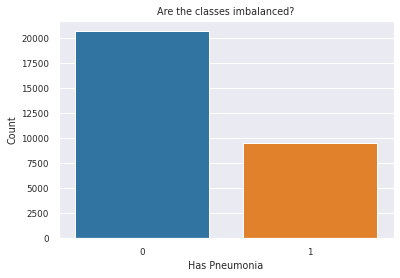

In [0]:
ax = sns.countplot(df['Target'])
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')

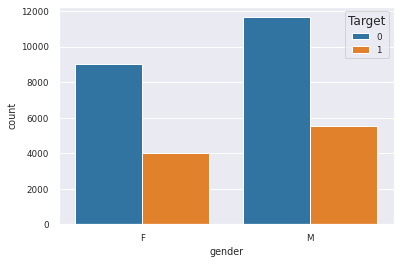

In [0]:
ax = sns.countplot(df['gender'], hue=df['Target'])

In [0]:
boxes_per_patient = df.groupby(['patientId'])['Target'].sum()

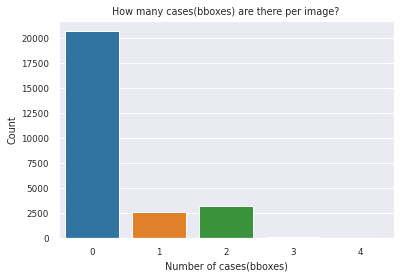

In [0]:
ax = sns.countplot(boxes_per_patient)
_ = ax.set_title('How many cases(bboxes) are there per image?')
_ = ax.set_xlabel('Number of cases(bboxes)')
_ = ax.set_ylabel('Count')

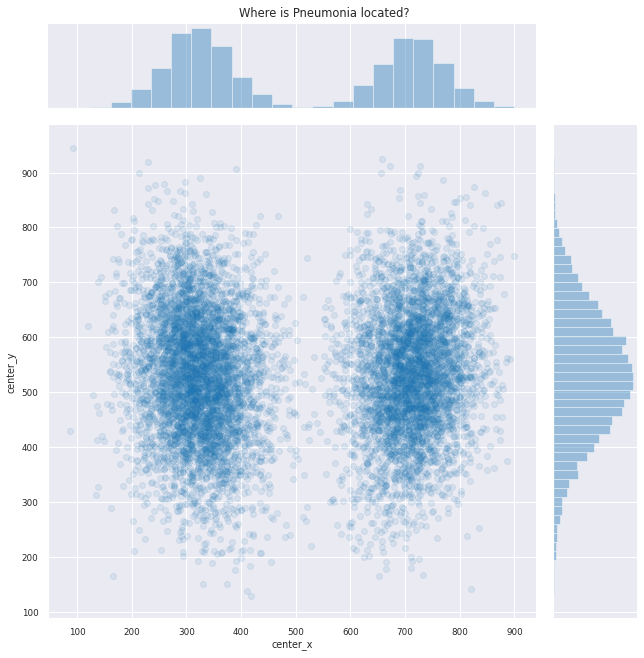

In [0]:
ax = sns.jointplot("center_x", "center_y", data=df, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

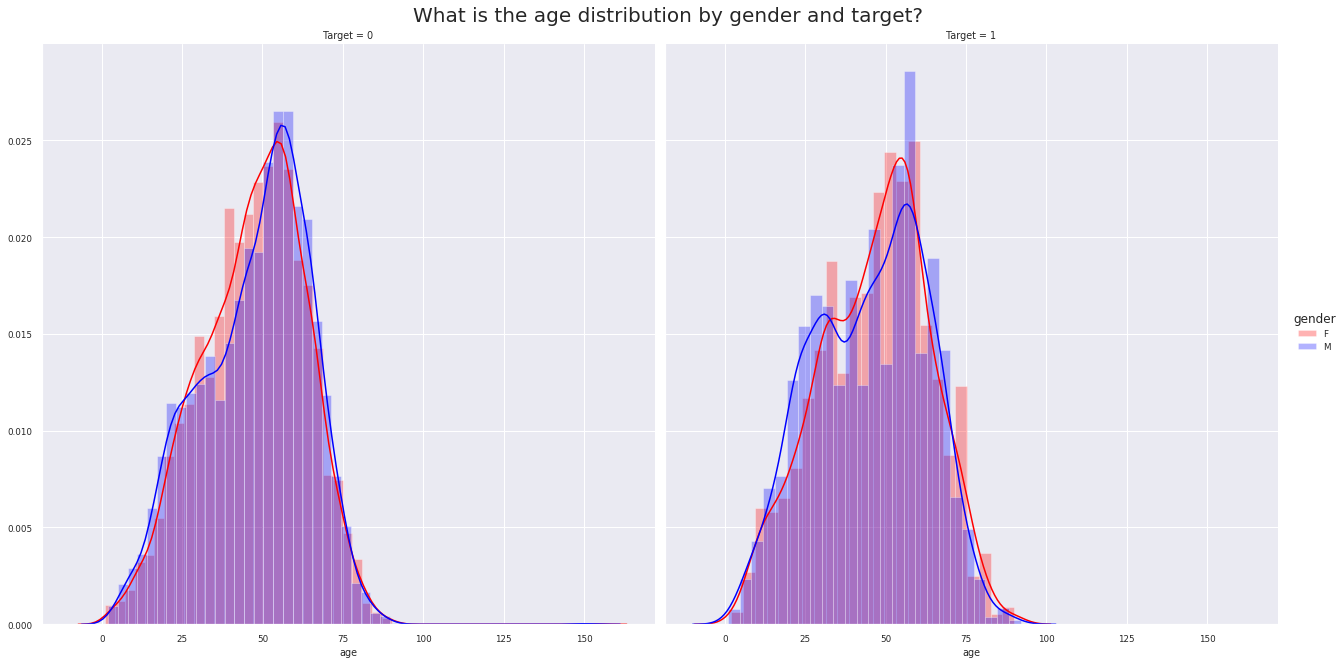

In [0]:
g = sns.FacetGrid(col='Target', hue='gender', 
                  data=df.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'age', hist_kws={'alpha': 0.3}).add_legend()
_ = g.fig.suptitle("What is the age distribution by gender and target?", y=1.02, fontsize=20)

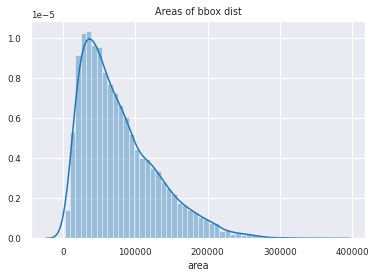

In [0]:
ax = sns.distplot(df.dropna(subset=['area'])['area'])
_ = ax.set_title('Areas of bbox dist')

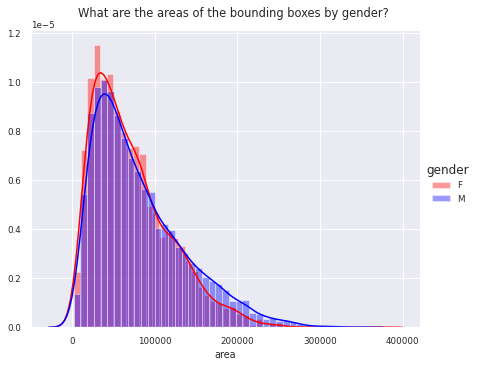

In [0]:
g = sns.FacetGrid(
    data=df.dropna(subset=['area']),
    hue="gender",
    height=5, palette=dict(F="red", M="blue"), aspect=1.2)
_ = g.map(sns.distplot, "area").add_legend()
_ = g.fig.suptitle('What are the areas of the bounding boxes by gender?', y=1.01)

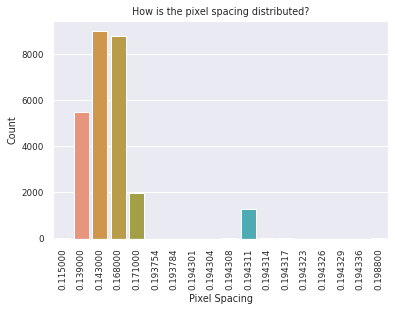

In [0]:
ax = sns.countplot(df.drop_duplicates('patientId')['pixel_spacing'])
_ = ax.set_xticklabels(["{0:.6f}".format(round(float(i._text), 6)) for i in ax.get_xticklabels()])
_ = ax.set_xlabel('Pixel Spacing')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Count')
_ = ax.set_title('How is the pixel spacing distributed?')

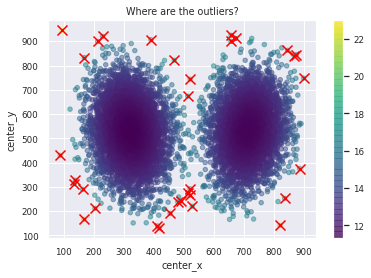

In [0]:
from sklearn.mixture import GaussianMixture
threshold = 17
clf = GaussianMixture(n_components=2)
df_centers = df.dropna(subset=['x'])[['center_x', 'center_y']]
clf.fit(df_centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(df_centers[['center_x', 'center_y']])
Z = -clf.score_samples(df_centers[['center_x', 'center_y']])
df_outliers = df_centers.iloc[Z > threshold]
fig, ax = plt.subplots()
df_centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
df_outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?')

In [0]:
import matplotlib.patches as patches

def get_image(patient_id, root_dir=os.path.join(RAWDATA_DIR, 'stage_2_train_images')):
    filename = os.path.join(root_dir, f'{patient_id}.dcm')
    dcm_data = pydicom.read_file(filename)
    return dcm_data.pixel_array

def draw_bboxes(bboxes, ax):
    for bbox in bboxes.itertuples():
        rect = patches.Rectangle(
            (bbox.x, bbox.y), bbox.width, bbox.height,
            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
def draw_image(df, patient_id, ax):
    img = get_image(patient_id)
    
    bboxes = df.loc[df.patientId == patient_id, ['x', 'y', 'width', 'height']]
    draw_bboxes(bboxes, ax)

    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.axis('off')

In [0]:
df[df.Target == 1][:10]

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,class,age,gender,view_position,pixel_spacing,mean_black_pixels
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,370.5,341.5,Lung Opacity,32,F,AP,0.139,0.002634
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,0.565121,115968.0,690.0,378.5,Lung Opacity,32,F,AP,0.139,0.002634
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,1.538462,16640.0,403.0,629.0,Lung Opacity,75,M,PA,0.143,0.054224
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,1.182482,22194.0,776.0,643.5,Lung Opacity,75,M,PA,0.143,0.054224
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,0.696296,12690.0,335.0,389.5,Lung Opacity,6,F,AP,0.168,0.506622
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1,0.721212,19635.0,606.5,381.5,Lung Opacity,6,F,AP,0.168,0.506622
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,0.688525,40992.0,390.0,666.0,Lung Opacity,23,F,AP,0.171,0.196528
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1,0.725352,58504.0,753.0,653.0,Lung Opacity,23,F,AP,0.171,0.196528
19,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,0.407115,104236.0,284.0,437.0,Lung Opacity,58,M,AP,0.139,0.002476
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1,0.483193,109480.0,686.0,513.0,Lung Opacity,58,M,AP,0.139,0.002476


14    Lung Opacity
15    Lung Opacity
Name: class, dtype: object


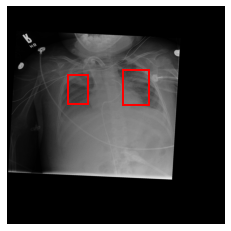

In [0]:
patient_id = '00aecb01-a116-45a2-956c-08d2fa55433f'
_, ax = plt.subplots()
print(df[df.patientId == patient_id]['class'])
draw_image(df, patient_id, ax)

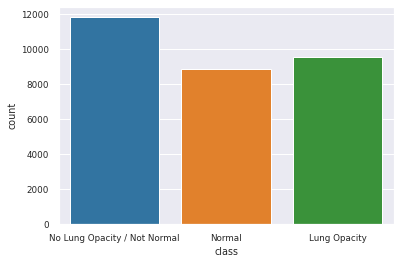

In [0]:
sns.countplot(df['class'])
_ = ax.set_title('Class dist')
_ = ax.set_xlabel('Class')
_ = ax.set_ylabel('Count')

In [0]:
df.groupby(['class', 'Target']).size()

class                         Target
Lung Opacity                  1          9555
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64